# Logistic Regression 

In [5]:
DATA_DIR = 'data'

In [1]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
import os

In [104]:
#creating spark session
spark = SparkSession.builder.appName('sentimentAnalysis').getOrCreate()

In [7]:
pre_processed_train_data = spark.read.parquet(os.path.join(DATA_DIR, 'train.parquet'))

In [92]:
pre_processed_train_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- data_prep: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vect: vector (nullable = true)
 |-- features: vector (nullable = true)



Let's test some parameters, so we can chose the ones we will use int the model afterwards

In [54]:
%%time 

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rdc = LogisticRegression()

paramGrid = ParamGridBuilder().addGrid(rdc.maxIter, [5, 10, 15])\
                              .addGrid(rdc.regParam, [0.0001, 0.001, 0.0005])\
                              .addGrid(rdc.elasticNetParam, [0.2, 0.3, 0.4])\
                              .build()
evaluator = BinaryClassificationEvaluator()
valid = TrainValidationSplit(estimator = rdc,
                             estimatorParamMaps=paramGrid,
                             evaluator = evaluator,
                             trainRatio = 0.50)
model = valid.fit(pre_processed_train_data)
best_model = model.bestModel
result = best_model.transform(pre_processed_train_data)

CPU times: user 2.39 s, sys: 581 ms, total: 2.97 s
Wall time: 3min 31s


In [29]:
def evaluate(result):
    predictionAndLabels = result
    metrics = ["areaUnderROC","areaUnderPR"]
    for m in metrics:
        evaluator = BinaryClassificationEvaluator(metricName=m)
        print(str(m) + ": " + str(evaluator.evaluate(predictionAndLabels)))

In [99]:
evaluate(result)

areaUnderROC: 0.7853881807440036
areaUnderPR: 0.7817562182134117


In [97]:
best_model.extractParamMap()

{Param(parent='LogisticRegression_6595ef6781f7', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_6595ef6781f7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.3,
 Param(parent='LogisticRegression_6595ef6781f7', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_6595ef6781f7', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_6595ef6781f7', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_6595ef6781f7', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_6595ef6781f7', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [57]:
model.extractParamMap()

{Param(parent='TrainValidationSplitModel_72e0bb3e2657', name='seed', doc='random seed.'): 1215852686270291499,
 Param(parent='TrainValidationSplitModel_72e0bb3e2657', name='estimator', doc='estimator to be cross-validated'): LogisticRegression_34e71a7cd7bf,
 Param(parent='TrainValidationSplitModel_72e0bb3e2657', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LogisticRegression_34e71a7cd7bf', name='maxIter', doc='max number of iterations (>= 0).'): 5,
   Param(parent='LogisticRegression_34e71a7cd7bf', name='regParam', doc='regularization parameter (>= 0).'): 0.0001,
   Param(parent='LogisticRegression_34e71a7cd7bf', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
  {Param(parent='LogisticRegression_34e71a7cd7bf', name='maxIter', doc='max number of iterations (>= 0).'): 5,
   Param(parent='LogisticRegression_34e71a7cd7bf', name='regParam', doc=

In [58]:
!pip install emoji --upgrade

     |████████████████████████████████| 51kB 906kB/s eta 0:00:01
  Stored in directory: /Users/carolinaabs/Library/Caches/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [59]:
import emoji
print(emoji.emojize(' :trophy: The winner parameters are: maxIter = 10 regParam = 0.001 elasticNetParam = 0.3 !!!! :trophy: '))

 🏆 The winner parameters are: maxIter = 10 regParam = 0.001 elasticNetParam = 0.3 !!!! 🏆 


In [60]:
pre_processed_test_data = spark.read.parquet(os.path.join(DATA_DIR, 'test.parquet'))

In [100]:
def logistic_regression_classifier(training_df, testing_df):
    """
    Apply Logistic Regression Classifier to test data for predicting sentiment of Tweets.
    :param training_df: Trained labelled data
    :param testing_df: Test data
    :return: transformed dataframe of predicted labels for tweets
    """
    lor = LogisticRegression(regParam = 0.001, maxIter = 10, elasticNetParam = 0.3)
    model = lor.fit(training_df.drop('features').withColumnRenamed('count_vect', 'features'))
    return model.transform(testing_df.drop('features').withColumnRenamed('count_vect', 'features')), model.summary

In [101]:
result_lr, summary = logistic_regression_classifier(pre_processed_train_data, pre_processed_test_data)

In [81]:
import pandas as pd

def confusion_matrix(result_df):
    """
    Generate Confusion Matrix for showing the performance of algorithm.
    :param result_df: Dataframe returned from the model
    :return: pandas dataframe
    """
    true_positives = result_df.filter((result_df.label == 1.0) & (result_df.prediction == 1.0)).count()
    true_negatives = result_df.filter((result_df.label == 0.0) & (result_df.prediction == 0.0)).count()
    false_positives = result_df.filter((result_df.label == 0.0) & (result_df.prediction == 1.0)).count()
    false_negatives = result_df.filter((result_df.label == 1.0) & (result_df.prediction == 0.0)).count()

    matrix = {"Positive": pd.Series([true_positives, false_positives], index=["Positive", "Negative"]),
              "Negative": pd.Series([false_negatives, true_negatives], index=["Positive", "Negative"])}

    df = pd.DataFrame(matrix)
    df.columns.name = "Actual / Predicted"
    return df

# Metrics

In [82]:
confusion_matrix(result_lr)

Actual / Predicted,Positive,Negative
Positive,204013,36138
Negative,107265,132456


In [73]:
def calculate_accuracy(result_df):
    """
    Calculate accuracy of model against actual data.
    :param result_df: Dataframe returned from the model
    :return: accuracy between 0 and 1
    """
    return 1.0 * result_df.filter(result_df.label == result_df.prediction).count() / result_df.count()

In [74]:
calculate_accuracy(result_lr)

0.701164060416111

In [83]:
roc = summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(summary.areaUnderROC))

0.788047461328519

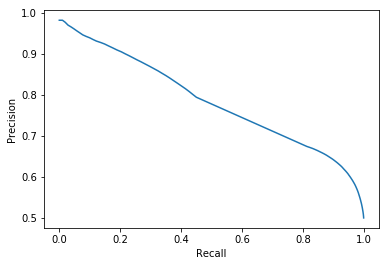

In [88]:
import matplotlib.pyplot as plt

pr = summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

**1. Model optimization**
* If we imagine that we are designing this model for use in a company application, we know that the company does *not* want positive reviews to be categorized as negative. That is, we want to have as few **false positives** as possible. 
* On the other hand, if our manager <img src='notebook_ims/manager.jpg' width=8% /> asks for an application that will catch almost *all* cases of negative reviews, even if it means a higher number of false positives, then we'd want as few **false negatives** as possible.
* To train according to specific product demands and goals, we do not want to optimize for accuracy only. Instead, we want to optimize for a metric that can help us decrease the number of false positives or negatives. 

<img src='notebook_ims/precision_recall.png' width=40% />
     

**2. Imbalanced training data**
* At the start of this notebook, we saw that about 10 % of the data was labeled as false negatives. So, even if a model labels **all** of our data as valid, it will still have a poor accuracy. 
* This may result in some overfitting towards valid data, which accounts for some **false negatives**; cases in which negative reviews (0) are incorrectly characterized as positive (1).

So, let's address these issues in order; first, tuning our model and optimizing for a specific metric during training, and second, accounting for class imbalance in the training set. 

**Scenario:**
* A company has asked you to build a model that detects cases of positive reviews with an accuracy of about 85%. 

In this case, we want to build a model that has as many true positives and as few false negatives, as possible. This corresponds to a model with a high **recall**: true positives / (true positives + false negatives). 

HOW TO DO IT USING SPARK?

I will assume that performance on a training set will be within about 5% of the performance on a test set. So, for a recall of about 85%, I'll aim for a bit higher, 90%.